In [19]:
import os

from ffmpeg import FFmpeg, Progress
import ffprobe
import subprocess

from matplotlib import pyplot as plt
from skimage import measure
import numpy as np
import pandas as pd
import json
import cv2

In [20]:
import warnings
warnings.filterwarnings('ignore')

In [21]:
# Задаем основные параметры.
input_path = 'src/original.mp4'
codec = 'libx265'

encoded_files_size = []

In [22]:
res = subprocess.check_output(['ffprobe', '-i', input_path, '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams'])

data = json.loads(res)
size = int(data['format']['size']) / (1024 * 1024)

encoded_files_size.append(size)

print('[notice] Размер исходного файла {:.3f} Mb'.format(size))

[notice] Размер исходного файла 4.770 Mb


In [23]:
keys = ['frame_type', 'codec_type', 'frame_num', 'pts', 'pts_time', 'best_effort_timestamp', 
        'best_effort_timestamp_time', 'pkt_duration', 'pkt_duration_time', 'pkt_size', 'width', 
        'height', 'pix_fmt', 'sample_aspect_ratio', 'pict_type', 'coded_picture_number', 
        'display_picture_number', 'interlaced_frame', 'top_field_first', 'repeat_pict', 
        'color_range', 'color_space', 'color_transfer', 'color_primaries', 'chroma_location', 
        'timecode', 'refs', 'is_avc', 'nal_length_size']

### Задание 1.
Необходимо получить фрагмент, закодированный с использованием только предсказанием вперед (P-кадры) на один кадр.

In [24]:
output_path = 'res/task-1.mp4'

cmd = [
    # Вызываем утилиту ffmpeg для кодирования видео.
    'ffmpeg',
    # Перезаписываем выходной файл, если он уже существует.
    '-y',
    # Исходное видео.
    '-i', input_path,
    # Кодек libx265 для видео.
    '-c:v', codec,
    # Задает количество ссылок на изображения для использования при кодировании.
    '-refs', '1',
    # Устанавливает параметры кодирования x265, такие как интервал
    # ключевых кадров и количество B-кадров, используемых для предсказания.
    '-x265-params', 'keyint=2',
    # Указывает на использование только P-кадров для кодирования видео
    '-coder', '0',
    # Указывает на отсутствие B-кадров
    '-bf', '0',
    # Выходной файл.
    output_path,
]

res = subprocess.call(cmd)

if res == 0:
    print('[notice] ✔ Successful video file processing')
else:
    print('[notice] Something went wrong :(')

[notice] ✔ Successful video file processing


##### Проверка

In [25]:
cmd = ['ffprobe', '-show_frames', '-print_format', 'csv', output_path]
result = subprocess.run(cmd, capture_output=True, text=True)
lines = result.stdout.split('\n')

data = pd.DataFrame()
for line in lines:
    if 'video' in line:
        values = line.split(',')
        d = {keys[i]: values[i] for i in range(len(keys))}
        data = data.append([d])

data['top_field_first']


0    I
0    P
0    I
0    P
0    I
    ..
0    I
0    P
0    I
0    P
0    I
Name: top_field_first, Length: 395, dtype: object

In [26]:
res = subprocess.check_output(['ffprobe', '-i', output_path, '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams'])

data = json.loads(res)
size = int(data['format']['size']) / (1024 * 1024)

encoded_files_size.append(size)

print('[notice] Размер полученного файла {:.3f} Mb'.format(size))

[notice] Размер полученного файла 5.944 Mb


### Задание 2.
Получить фрагмент, закодированный с использованием только предсказанием вперед (P-кадры) на четыре кадра максимально.

In [27]:
output_path = 'res/task-2.mp4'

cmd = [
    # Вызываем утилиту ffmpeg для кодирования видео.
    'ffmpeg',                               
    # Перезаписываем выходной файл, если он уже существует.
    '-y',                                   
    # Исходное видео.
    '-i', input_path,
    # Кодек libx265 для видео.
    '-c:v', codec,
    # Количество P-кадров, на которые может ссылаться B-кадр
    # (если они используются).
    '-refs', '4',
    # Параметры кодека x265, где keyint=4 указывает, что I- и P-кадры
    # будут создаваться каждые 4 кадра, а bframes=0 говорит, что
    # используются только P-кадры без B-кадров.
    '-x265-params', 'keyint=4:bframes=0',
    # Копирование аудио потока без изменений.
    '-c:a', 'copy',
    # Выходной файл.
    output_path,
]

res = subprocess.call(cmd)

if res == 0:
    print('[notice] ✔ Successful video file processing')
else:
    print('[notice] Something went wrong :(')

[notice] ✔ Successful video file processing


##### Проверка

In [28]:
cmd = ['ffprobe', '-show_frames', '-print_format', 'csv', output_path]
result = subprocess.run(cmd, capture_output=True, text=True)
lines = result.stdout.split('\n')

data = pd.DataFrame()
for line in lines:
    if 'video' in line:
        values = line.split(',')
        d = {keys[i]: values[i] for i in range(len(keys))}
        data = data.append([d])

data['top_field_first']

0    I
0    P
0    P
0    P
0    I
    ..
0    P
0    P
0    I
0    P
0    P
Name: top_field_first, Length: 395, dtype: object

In [29]:
res = subprocess.check_output(['ffprobe', '-i', output_path, '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams'])

data = json.loads(res)
size = int(data['format']['size']) / (1024 * 1024)

encoded_files_size.append(size)

print('[notice] Размер полученного файла {:.3f} Mb'.format(size))

[notice] Размер полученного файла 3.737 Mb


### Задание 3.
Получить фрагмент, закодированный с использованием только предсказанием вперед и назад (P и B -кадры).

In [30]:
output_path = 'res/task-3.mp4'

cmd = [
    # Вызываем утилиту ffmpeg для кодирования видео.
    'ffmpeg',
    # Перезаписываем выходной файл, если он уже существует.
    '-y',
    # Исходное видео.
    '-i', input_path,
    # Кодек libx265 для видео.
    '-c:v', codec,
    # Задает количество ссылок на изображения для использования при кодировании.
    '-refs', '1',
    # Устанавливает параметры кодирования x265, такие как интервал
    # ключевых кадров и количество B-кадров, используемых для предсказания.
    '-x265-params','keyint=24:bframes=2',
    # Копирование аудио потока без изменений.
    '-c:a', 'copy',
    # Выходной файл.
    output_path
]

res = subprocess.call(cmd)

if res == 0:
    print('[notice] ✔ Successful video file processing')
else:
    print('[notice] Something went wrong :(')

[notice] ✔ Successful video file processing


##### Проверка

In [31]:
cmd = ['ffprobe', '-show_frames', '-print_format', 'csv', output_path]
result = subprocess.run(cmd, capture_output=True, text=True)
lines = result.stdout.split('\n')

data = pd.DataFrame()
for line in lines:
    if 'video' in line:
        values = line.split(',')
        d = {keys[i]: values[i] for i in range(len(keys))}
        data = data.append([d])

data['top_field_first']

0    I
0    B
0    B
0    P
0    B
    ..
0    B
0    P
0    B
0    B
0    P
Name: top_field_first, Length: 395, dtype: object

In [32]:
res = subprocess.check_output(['ffprobe', '-i', output_path, '-v', 'quiet', '-print_format', 'json', '-show_format', '-show_streams'])

data = json.loads(res)
size = int(data['format']['size']) / (1024 * 1024)

encoded_files_size.append(size)

print('[notice] Размер полученного файла {:.3f} Mb'.format(size))

[notice] Размер полученного файла 1.499 Mb


### Задание 4.
Оценить качество полученного видеоряда и сравнить поведение графиков качества и объема видеофайлов в зависимости от вида применяемого кодирования.

In [33]:
original_file = 'src/original.mp4'
encoded_files = ['res/task-1.mp4', 'res/task-2.mp4', 'res/task-3.mp4']

In [34]:
ssim_plot_data = []

# Загрузка оригинального видео.
original_cap = cv2.VideoCapture(original_file)
original_frames = []
while original_cap.isOpened():
    ret, frame = original_cap.read()
    if not ret:
        break
    original_frames.append(frame)
original_cap.release()

# Вычисление SSIM для каждого закодированного видео.
for encoded_file in encoded_files:
    encoded_cap = cv2.VideoCapture(encoded_file)
    encoded_frames = []
    while encoded_cap.isOpened():
        ret, frame = encoded_cap.read()
        if not ret:
            break
        encoded_frames.append(frame)
    encoded_cap.release()
    
    total_ssim = 0
    for i in range(len(original_frames)):
        original_gray = cv2.cvtColor(original_frames[i], cv2.COLOR_BGR2GRAY)
        encoded_gray = cv2.cvtColor(encoded_frames[i], cv2.COLOR_BGR2GRAY)
        ssim_score = measure.compare_ssim(original_gray, encoded_gray, data_range=encoded_gray.max() - encoded_gray.min())
        total_ssim += ssim_score

    avg_ssim = total_ssim / len(original_frames)
    ssim_plot_data.append(avg_ssim)
    print(f"[notice] SSIM score for {encoded_file}: {round(avg_ssim, 4)}")

[notice] SSIM score for res/task-1.mp4: 0.9804
[notice] SSIM score for res/task-2.mp4: 0.9814
[notice] SSIM score for res/task-3.mp4: 0.9799


In [35]:
psnr_plot_data = []

# Загрузка оригинального видео.
original_cap = cv2.VideoCapture(original_file)
original_frames = []
while original_cap.isOpened():
    ret, frame = original_cap.read()
    if not ret:
        break
    original_frames.append(frame)
original_cap.release()

# Вычисление PSNR для каждого закодированного видео.
for encoded_file in encoded_files:
    encoded_cap = cv2.VideoCapture(encoded_file)
    encoded_frames = []
    while encoded_cap.isOpened():
        ret, frame = encoded_cap.read()
        if not ret:
            break
        encoded_frames.append(frame)
    encoded_cap.release()
    
    total_psnr = 0
    for i in range(len(original_frames)):
        mse = ((original_frames[i] - encoded_frames[i]) ** 2).mean()
        if mse == 0:
            psnr = 100
        else:
            psnr = 10 * np.log10((255 ** 2) / mse)
        total_psnr += psnr
    avg_psnr = total_psnr / len(original_frames)
    psnr_plot_data.append(avg_psnr)
    print(f"[notice] PSNR for {encoded_file}: {avg_psnr}")

[notice] PSNR for res/task-1.mp4: 38.911973740761105
[notice] PSNR for res/task-2.mp4: 39.16994699335448
[notice] PSNR for res/task-3.mp4: 38.80319935618616


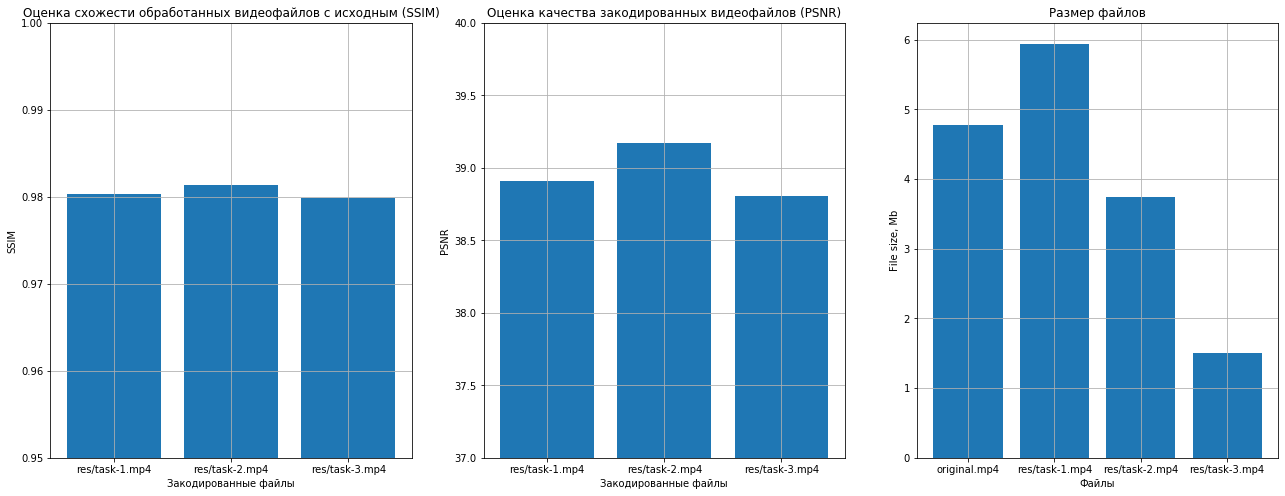

In [56]:
original_file = 'src/original.mp4'
encoded_files = ['res/task-1.mp4', 'res/task-2.mp4', 'res/task-3.mp4']

plt.figure(figsize=(22,8))

plt.subplot(1,3,1)
plt.title("Оценка схожести обработанных видеофайлов с исходным (SSIM)")
plt.xlabel("Закодированные файлы")
plt.ylabel("SSIM")
plt.ylim([.95, 1])
plt.grid()
plt.bar(encoded_files, ssim_plot_data, label="SSIM")

plt.subplot(1,3,2)
plt.title("Оценка качества закодированных видеофайлов (PSNR)")
plt.xlabel("Закодированные файлы")
plt.ylabel("PSNR")
plt.ylim([37, 40])
plt.grid()
plt.bar(encoded_files, psnr_plot_data, label="PSNR")

plt.subplot(1,3,3)
plt.title("Размер файлов")
plt.xlabel("Файлы")
plt.ylabel("File size, Mb")
encoded_files.insert(0, 'original.mp4')
plt.bar(encoded_files, encoded_files_size, label="size")

plt.grid()
plt.show()